In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)


### Get the data

In [2]:
# Loading data
transform = ToTensor()

train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)


100%|██████████| 9912422/9912422 [00:00<00:00, 32277950.71it/s]


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68983880.31it/s]


Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26676533.83it/s]


Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20159289.70it/s]

Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



### the main function

In [3]:
def main(train_loader, test_loader):

    # Defining model and training options
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, embed_dim = 32, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 10
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

### This is only the first part of the ViT, containing only convolutional projection and tokenization


In [4]:
class MyMiniViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, embed_dim = 32, hidden_d = 8):
    # Super constructor
    super(MyMiniViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)

    # 1) Projector and Linear mapper (perhaps we can get by without the Linear mapper?)
    in_chans = chw[0]
    self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=self.patch_size, stride=self.patch_size)
    self.linear_mapper = nn.Linear(embed_dim, hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, hidden_d))

  def forward(self, images):

    patches = self.proj(images).flatten(2).transpose(1, 2)#.to(self.positional_embeddings.device)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
    return tokens

In [5]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result


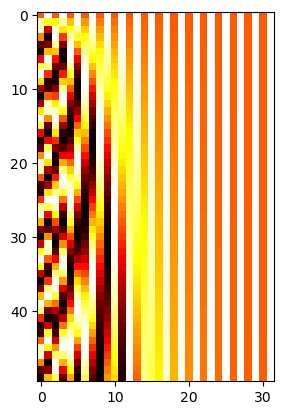

In [6]:
import matplotlib.pyplot as plt

plt.imshow(get_positional_embeddings(50, 32), cmap="hot", interpolation="nearest")
plt.show()

In [7]:
#This is only the first part of the ViT plus positional embeddings
class MyMidiViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, embed_dim = 32, hidden_d = 8):
    # Super constructor
    super(MyMidiViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)

    # 1) Projector and Linear mapper (perhaps we can get by without the Linear mapper?)
    in_chans = chw[0]
    self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=self.patch_size, stride=self.patch_size)
    self.linear_mapper = nn.Linear(embed_dim, hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, hidden_d))

    # 3) Positional embedding
    # n_patches ** 2 + 1 is the number of tokens: one per patch (n_patches^2)  plus learnable token
    self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(n_patches ** 2 + 1, hidden_d)))
    self.pos_embed.requires_grad = False


  def forward(self, images):
    n, c, h, w = images.shape
    patches = self.proj(images).flatten(2).transpose(1, 2)#.to(self.positional_embeddings.device)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(n, 1, 1)
    out = tokens + pos_embed
    return tokens


In [8]:
tst_image,_ = test_set[0]
tst_image = tst_image.unsqueeze(0)
tst_image.shape

torch.Size([1, 1, 28, 28])

In [9]:
mini = MyMiniViT()
midi = MyMidiViT()

/tmp/ipykernel_26019/3107864954.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(n_patches ** 2 + 1, hidden_d)))


In [10]:
tokens=mini(tst_image)
tokens.shape

torch.Size([1, 50, 8])

In [11]:
# This is multi-head self-attention submodule

class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            #import ipdb; ipdb.set_trace()
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


# This is multi-head self-attention submodule packaged in  block with a residual connection

class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        return out


In [12]:
# Complete ViT

class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, embed_dim = 32, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)

        # 1) Projector and Linear mapper (perhaps we can get by without the Linear mapper?)
        in_chans = chw[0]
        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=self.patch_size, stride=self.patch_size)
        self.linear_mapper = nn.Linear(embed_dim, hidden_d)

        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = self.proj(images).flatten(2).transpose(1, 2).to(self.positional_embeddings.device)
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution


    



In [13]:
maxi = MyViT((1, 28, 28), n_patches=7, n_blocks=2, embed_dim = 32, hidden_d=8, n_heads=2, out_d=10)
out=maxi(tst_image)
out.shape

torch.Size([1, 10])

In [14]:
main(train_loader, test_loader)

Using device:  cuda:1 (NVIDIA GeForce RTX 4090)


Training:   0%|          | 0/10 [00:00<?, ?it/s]/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Training:  10%|█         | 1/10 [01:51<16:46, 111.78s/it]

Epoch 1/10 loss: 2.12


Training:  20%|██        | 2/10 [03:31<13:55, 104.47s/it]

Epoch 2/10 loss: 1.95


Training:  30%|███       | 3/10 [05:06<11:42, 100.42s/it]

Epoch 3/10 loss: 1.91


Training:  40%|████      | 4/10 [06:41<09:48, 98.16s/it] 

Epoch 4/10 loss: 1.89


Training:  50%|█████     | 5/10 [08:24<08:20, 100.05s/it]

Epoch 5/10 loss: 1.88


Training:  60%|██████    | 6/10 [10:13<06:51, 102.82s/it]

Epoch 6/10 loss: 1.87


Training:  70%|███████   | 7/10 [11:50<05:03, 101.23s/it]

Epoch 7/10 loss: 1.86


Training:  80%|████████  | 8/10 [13:28<03:19, 99.99s/it] 

Epoch 8/10 loss: 1.85


Training:  90%|█████████ | 9/10 [15:02<01:38, 98.15s/it]

Epoch 9/10 loss: 1.84


Training: 100%|██████████| 10/10 [16:53<00:00, 101.34s/it]


Epoch 10/10 loss: 1.82


Testing: 100%|██████████| 79/79 [00:04<00:00, 19.68it/s]

Test loss: 1.80
Test accuracy: 66.09%
